In [1]:
import numpy as np
from numpy.linalg import norm as norm
from numpy.linalg import eigh as eig
from copy import deepcopy as deepcopy
import sys
 
#implement step-size idea
#minimize the mse, E|\delta|^2, 
    
# np.random.seed(1)
np.random.seed()
print('random number:', np.random.randn())
print('random number:', np.random.randn())
# nn = Network((2, 3, 1), (Relu, Sigmoid))

# print(nn.w)
# print(nn.b)
# print(nn.activations)

#based on bp
#let's examine the training error in each layer during layer-by-layer training. 
#my hypothesis: training on layer L-1 can increase the training error for L.


class MSE:
    def __init__(self, activation_fn):
        """
        :param activation_fn: Class object of the activation function.
        """
        self.activation_fn = activation_fn

    def activation(self, z):
        return self.activation_fn.activation(z)

    @staticmethod
    def loss(y_true, y_pred):
        """
        :param y_true: (array) One hot encoded truth vector.
        :param y_pred: (array) Prediction vector
        :return: (flt)
        """
        return np.mean((y_pred - y_true)**2)

    @staticmethod
    def prime(y_true, y_pred):
        return y_pred - y_true

    def delta(self, y_true, y_pred):
        """
        Back propagation error delta
        :return: (array)
        """
        return self.prime(y_true, y_pred) * self.activation_fn.prime(y_pred)
   

class Relu:
    @staticmethod
    def activation(z):
        z[z < 0] = 0
        return z
    
    @staticmethod
    def prime(z):
        g = np.zeros_like(z)
        g[np.nonzero(z)] = 1.0
        return g

# x_test = np.array([[3, 0, 0], [0, 4, 0], [5, 6, 0]])
# print(x_test)
# print(Relu.prime(x_test))

    
class Sigmoid:
    @staticmethod
    def activation(z):
        return 1 / (1 + np.exp(-z))
    
    @staticmethod
    def prime(z):
        return Sigmoid.activation(z) * (1 - Sigmoid.activation(z))
    



random number: 2.4973339686914833
random number: 0.8677167851303886


In [2]:

class Network:
    def __init__(self, dimensions, activations):
        """
        :param dimensions: (tpl/ list) Dimensions of the neural net. (input, hidden layer, output)
        :param activations: (tpl/ list) Activations functions.

        """

        self.n_layers = len(dimensions)
        self.loss = None
        self.learning_rate = None
        self.dimensions = dimensions

        # Weights and biases are initiated by index. For a one hidden layer net you will have a w[1] and w[2]
        self.w = {}
        self.b = {}
        
        self.w_err = {}
        self.b_err = {}
        

        # Activations are also initiated by index. For the example we will have activations[2] and activations[3]
        self.activations = {}

        for i in range(len(dimensions) - 1):
            self.w[i + 1] = np.random.randn(dimensions[i], dimensions[i + 1]) / np.sqrt(dimensions[i])
            self.b[i + 1] = np.random.randn(dimensions[i + 1])#np.zeros(dimensions[i + 1])
            self.activations[i + 2] = activations[i]
            
        #self.init_w2_bysearch()
            
        self.total_updates = 0 #total updates to layer 1        

        self.step_size=None#step-size for layer 1 
        self.step_sizes=[]
        self.delta1_before=[]#old residual before applying the update to w1 using the step-size
        self.delta1_after1=[]#new residual computed from derivation of the step-size
        self.delta1_after2=[]#new residual measured with the updated w
        self.ratios=[]
   
        self.norm_params = None    
    
    def init_w2_bysearch(self):
        '''search for a well-conditioned initialization for w2'''
        ind = self.n_layers - 1 
        dim = self.dimensions
        
        k2_min = np.inf
        for _ in range(10):
            w2 = np.random.randn(dim[ind], dim[ind-1]) / np.sqrt(dim[ind-1])
            print('w2.T*w2.shape', w2.T.dot(w2).shape)
            lam, _ = eig(w2.T.dot(w2))
            print('--how many eigenvalues:{}'.format(len(lam)))
            k2 = max(lam)/min(lam) 
            print('k2=', k2)
            if k2 < k2_min:
                k2_min = k2
                self.w[i] = w2
        
        
    def _feed_forward(self, x):
        """
        Execute a forward feed through the network.

        :param x: (array) Batch of input data vectors.
        :return: (tpl) Node outputs and activations per layer. 
                 The numbering of the output is equivalent to the layer numbers.
        """

        # w(x) + b
        z = {}

        # activations: f(z)
        a = {1: x}  # First layer has no activations as input. The input x is the input.

        for i in range(1, self.n_layers):
            # current layer = i
            # activation layer = i + 1
            z[i + 1] = np.dot(a[i], self.w[i]) + self.b[i]
            a[i + 1] = self.activations[i + 1].activation(z[i + 1])

        return z, a
     
        
    def predict(self, x):
        """
        :param x: (array) Containing parameters
        :return: (array) A 2D array of shape (n_cases, n_classes).
        """
        _, a = self._feed_forward(x)
        return a[self.n_layers]
    
    
    def _update_w_b(self, index, dw, delta):
        """
        Update weights and biases.

        :param index: (int) Number of the layer
        :param dw: (array) Partial derivatives
        :param delta: (array) Delta error.
        """

        if index == 1:
            lr = self.step_size
#             lr = self.learning_rate #using the constant step-size
        else:
            lr = self.learning_rate      
        self.w[index] -= lr * dw
        self.b[index] -= lr * np.mean(delta, 0)
        
    def _compute_grad_delta(self, z, a, y_true):
        # In case of three layer net will iterate over i = 2 and i = 1
        # Determine partial derivative and delta for the rest of the layers.
        # Each iteration requires the delta from the previous layer, propagating backwards.
        
        # Determine partial derivative and delta for the output layer.
        # delta output layer
        delta = self.loss.delta(y_true, a[self.n_layers])
        dw = np.dot(a[self.n_layers - 1].T, delta)

        update_params = {
            self.n_layers - 1: (dw, delta)
        }
        
        for i in reversed(range(2, self.n_layers)):
            delta = np.dot(delta, self.w[i].T) * self.activations[i].prime(z[i])
            dw = np.dot(a[i - 1].T, delta)
            update_params[i - 1] = (dw, delta)
            
        return update_params
        
        
    def _compute_norm(self, z, a, y_true):
        # In case of three layer net will iterate over i = 2 and i = 1
        # Determine partial derivative and delta for the rest of the layers.
        # Each iteration requires the delta from the previous layer, propagating backwards.
        
        # Determine partial derivative and delta for the output layer.
        # delta output layer
        delta = self.loss.delta(y_true, a[self.n_layers])
        dw = np.dot(a[self.n_layers - 1].T, delta)

        norm_params = {
            self.n_layers - 1: (norm(dw, 'fro'), norm(delta, 'fro'))
        }
        
        for i in reversed(range(2, self.n_layers)):
            delta = np.dot(delta, self.w[i].T) * self.activations[i].prime(z[i])
            dw = np.dot(a[i - 1].T, delta)
            norm_params[i - 1] = (norm(dw), norm(delta))
            
        return norm_params
        

    def conv_rate(self):
        w2 = self.get_w2()
        ww2 = w2.T.dot(w2)
        lam, _ = eig(ww2)
        print('eigenvalues: ', lam)
        return 1- min(lam)/max(lam)
    
    def compute_v(self, delta1, w2, z2):
        df = self.activations[2].prime(z2)
#         print('df.shape:', df.shape)
        n, n2 = delta1.shape
        V = - np.ones((n, 100))
        for i in range(n):
            V[i,:] = w2.T.dot(np.diag(df[i,:])).dot(w2).dot(delta1[i,:])
        return V
    

    def _compute_step_size(self, delta1, w2, z2):
        '''
        compute step-size according to our method for layer 1
        It is based on taking average of dot products
        
        alpha = E[delta * (v)] / E[||v||_2^2]
        where v = w2.T * (df) * w2 * delta
        with df = f^{2}'(z1), z1 = f^1(w1*x + b1) 
        '''
#         print('delta1.shape', delta1.shape)
        V = self.compute_v(delta1, w2, z2)
#         print('shape of V:', V.shape)
        n = V.shape[0] 
        alpha_1 = np.ones((n)) 
        alpha_2 = np.ones((n)) 
        delta1_norm2 = np.ones((n))
        for i in range(n):
            alpha_1[i] = V[i,:].dot(delta1[i,:])
            alpha_2[i] = V[i,:].dot(V[i,:])
            delta1_norm2[i] = delta1[i,:].dot(delta1[i,:])
        
        alpha = np.mean(alpha_1) / np.mean(alpha_2)
        
        #also compute the new residual norm from the derivation of the step-size
        delta1_norm2_mean = np.mean(delta1_norm2)
        ratio = 1- alpha *  np.mean(alpha_1) / delta1_norm2_mean
        
        delta1_norm2_mean_new1 = delta1_norm2_mean * ratio
        
        return 0.5 * alpha, delta1_norm2_mean, delta1_norm2_mean_new1, ratio # considering bias term
            
    def get_delta1(self, update_params):
        return update_params[1][1]

    
    def get_w2(self):
        '''shape of w2 is n2 by n1'''
        return self.w[2].T
    
    
    def _compute_norm_delta1_mean(self, param):
        delta1=self.get_delta1(param)
        d1 = norm(delta1, axis=1)
        d1 = np.multiply(d1, d1)
        return np.mean(d1)
        
        
    def _back_prop(self, z, a, y_true, x):
        """
        The input dicts keys represent the layers of the net.

        a = { 1: x,
              2: f(w1(x) + b1)
              3: f(w2(a2) + b2)
              }

        :param z: (dict) w(x) + b
        :param a: (dict) f(z)
        :param y_true: (array) One hot encoded truth vector.
        """

        update_params = self._compute_grad_delta(z, a, y_true)
        
        # delta1, w2, z2
        self.step_size, delta1_norm, delta1_norm_new1, ratio = self._compute_step_size(self.get_delta1(update_params), self.get_w2(), z[3])
        self.step_sizes.append(self.step_size)
        self.delta1_before.append(delta1_norm)
        self.delta1_after1.append(delta1_norm_new1)
        self.ratios.append(ratio)
        
        w_old = deepcopy(self.w)

    # Update the weights and biases
        for k, v in update_params.items():
            #add check when updating for layer 1
            if k == 1:
                #recompute z, a
                z_old, a_old = self._feed_forward(x)
                self.norm_params = self._compute_norm(z_old, a_old, y_true)
              
            #let's only update layer 1. 
            if k == 1:
                self._update_w_b(k, v[0], v[1])
            
            if k == 1:
                #recompute z, a
                z, a = self._feed_forward(x)
#                 print('difference in output is:', norm(a[self.n_layers] - a_old[self.n_layers]))
                params_new = self._compute_grad_delta(z, a, y_true)
                delta1_norm_new2= self._compute_norm_delta1_mean(params_new)
                self.delta1_after2.append(delta1_norm_new2)
                self.total_updates += 1 
        
                    
            #indeed only w[1] changes
#             self.w_err[k]=norm(w_old[k] - self.w[k])
#             print('w[{}] error:{}'.format(k, self.w_err[k]))
    
    def fit(self, x, y_true, loss, epochs, batch_size, learning_rate=1e-3):
        """
        :param x: (array) Containing parameters
        :param y_true: (array) Containing one hot encoded labels.
        :param loss: Loss class (MSE, CrossEntropy etc.)
        :param epochs: (int) Number of epochs.
        :param batch_size: (int)
        :param learning_rate: (flt)
        """
        if not x.shape[0] == y_true.shape[0]:
            raise ValueError("Length of x and y arrays don't match")
        # Initiate the loss object with the final activation function
        self.loss = loss(self.activations[self.n_layers])
        self.learning_rate = learning_rate

        delta1=[]
        delta2=[]
        grad1=[]
        grad2=[]
        losses = []
        for i in range(epochs):
            # Shuffle the data
            index = np.arange(x.shape[0])
            np.random.shuffle(index)
            x_ = x[index]
            y_ = y_true[index]

            for j in range(x.shape[0] // batch_size):
                k = j * batch_size
                l = (j + 1) * batch_size
                z, a = self._feed_forward(x_[k:l])
                self._back_prop(z, a, y_[k:l],  x_[k:l])

            if (i + 1) % 10 == 0:
                _, a = self._feed_forward(x)
                loss = self.loss.loss(y_true, a[self.n_layers])
                losses.append(loss)
                print("Loss:", loss)
                
            grad1.append(nn.norm_params[1][0])
            delta1.append(nn.norm_params[1][1])
            grad2.append(nn.norm_params[2][0])
            delta2.append(nn.norm_params[2][1])
        print('len(delta1):', len(delta1))
        return delta1, delta2, grad1, grad2, losses
    


#data: 1797
#data[0].shape (64,)


#data: 1797
#data[0].shape (64,)
eigenvalues:  [-2.26874328e-16 -1.91718207e-16 -1.80698801e-16 -1.63635644e-16
 -1.40680710e-16 -1.38692068e-16 -1.23876709e-16 -1.19192639e-16
 -1.16724601e-16 -1.03711843e-16 -1.02910175e-16 -1.00543211e-16
 -8.93818702e-17 -8.64713574e-17 -8.04693520e-17 -7.36580618e-17
 -7.06151994e-17 -7.06134293e-17 -6.10458018e-17 -6.02902982e-17
 -5.86108174e-17 -5.53211508e-17 -5.35280913e-17 -5.23783725e-17
 -4.63336687e-17 -4.42785021e-17 -4.12924274e-17 -4.08747548e-17
 -3.59583365e-17 -3.52142895e-17 -3.13065783e-17 -3.12264327e-17
 -2.95964638e-17 -2.84772898e-17 -2.33387550e-17 -2.18711755e-17
 -1.59329352e-17 -1.45809768e-17 -1.24428929e-17 -1.21329109e-17
 -1.05885392e-17 -6.55289641e-18 -5.67264799e-18 -4.87193477e-18
 -4.37648026e-18 -3.38801022e-18 -1.17681489e-18  1.66687935e-18
  1.93834382e-18  3.66242684e-18  4.85439532e-18  6.27625119e-18
  7.89176882e-18  8.01385276e-18  1.20181234e-17  1.25763716e-17
  1.57558207e-17  1.92682714e-17  2.0317233

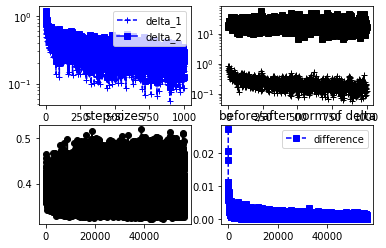

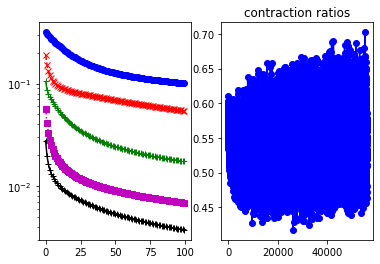

In [3]:


from sklearn import datasets
import sklearn.metrics
data = datasets.load_digits()

x = data["data"]
y = data["target"]
y = np.eye(10)[y]
print('#data:', len(x))
print('#data[0].shape', x[0].shape)

#input normalization (L2)
x = x / norm(x, axis = 1)[:, None]
for i in range(len(x)):
#     print('after normalization, norm(x[i])=', norm(x[i]))
    assert(abs(norm(x[i]) - 1.0) < 1e-8) 
    

num_epochs = 1000
b_size = 32
lr=1e-4

#delta2 also decreases, but variance is a bit high
#the variance of the grad2 is really high. 

nn = Network((64, 100, 10), (Relu, Sigmoid))
# nn = Network((64, 100, 10), (Relu, Relu))#why loss is nan?

print('convergence rate:', nn.conv_rate())
delta1, delta2, grad1, grad2, losses = nn.fit(x, y, loss=MSE, epochs=num_epochs, batch_size=b_size, learning_rate=lr)

prediction = nn.predict(x)

y_true = []
y_pred = []
for i in range(len(y)):
    y_pred.append(np.argmax(prediction[i]))
    y_true.append(np.argmax(y[i]))
print(sklearn.metrics.classification_report(y_true, y_pred))


import matplotlib.pyplot as plt
plt.figure(1)
plt.subplot(221)
plt.plot(delta1, '--b+', label='delta_1')
plt.plot(delta2, '-bs', label='delta_2')
plt.yscale('log')
plt.legend()

plt.subplot(222)
plt.plot(grad1, '--k+', label='grad_1')
plt.plot(grad2, '-ks', label='grad_2')
plt.yscale('log')

plt.subplot(223)
plt.plot(nn.step_sizes, '-ko', label='step-sizes')
plt.title('step-sizes')

plt.subplot(224)
diff = np.asarray(nn.delta1_before) - np.asarray(nn.delta1_after1)
#diff = np.asarray(nn.delta1_before) - np.asarray(nn.delta1_after2)
plt.plot(diff, '--bs', label='difference')
# plt.yscale('log')
plt.title('before/after norm of delta')
plt.legend()

plt.figure(2)
plt.subplot(221)
plt.plot(nn.delta1_before, '--r+', label='||delta1|| before')
plt.plot(nn.delta1_after1, '-bo', label='||delta1|| after1')
# plt.plot(nn.delta1_after2, '-.k*', label='||delta1|| after2(from measure on the new w)')
#this should be 0; but why not?
print('difference between two new deltas is:', norm(np.asarray(nn.delta1_after1) - np.asarray(nn.delta1_after2)))
plt.title('before/after norm of delta')
plt.yscale('log')
plt.xscale('log')
plt.legend()

print('#negatitive{} out of {}'.format(len(diff[np.where(diff<0)]), len(diff)))
assert(all(d >= 0.0 for d in diff))


def proc_data(learning_rate):
    loss_const = np.load('losses_const_'+str(learning_rate)+'.npy') 
    return np.mean(loss_const, axis=0), 'const lr='+str(learning_rate)

plt.subplot(121)
plt.yscale('log')
plt.plot(losses, '-k+', label='step-size')
loss_const1, label1 = proc_data(learning_rate=0.0001)
plt.plot(loss_const1, '--bo', label=label1)
loss_const2, label2 = proc_data(learning_rate=0.001)
plt.plot(loss_const2, '--rx', label=label2)
loss_const3, label3 = proc_data(learning_rate=0.01)
plt.plot(loss_const3, '-.g+', label=label3)
loss_const4, label4 = proc_data(learning_rate=0.1)
plt.plot(loss_const4, ':ms', label=label4)


plt.subplot(122)
plt.plot(nn.ratios, '-bo'), 
plt.title('contraction ratios')
print('average contraction ratio:', np.mean(nn.ratios))


#negatitive0 out of 56000
average contraction ratio: 0.5220016221560471


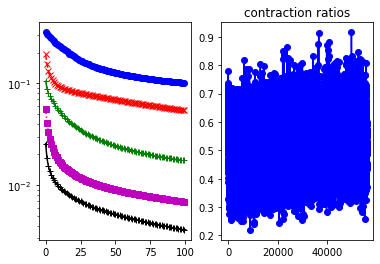

[16, 32, 64, 128, 256, 512, 1024]
batch_size= 16
Loss: 0.016946972790226496
Loss: 0.011732623318180006
Loss: 0.009938623059061237
Loss: 0.008753515155185148
Loss: 0.007987528433602288
Loss: 0.007394411161020917
Loss: 0.006714430658278257
Loss: 0.006194286034206545
Loss: 0.0058688069327638825
Loss: 0.0055670693183251
Loss: 0.005292235158084927
Loss: 0.00496667668308039
Loss: 0.004790395069027984
Loss: 0.004534072103404453
Loss: 0.004416143606668703
Loss: 0.0041612801534430316
Loss: 0.0040371161156785235
Loss: 0.00389564222655192
Loss: 0.003723611973706804
Loss: 0.0036019782766806853
Loss: 0.0034856159822451286
Loss: 0.0033741083933369964
Loss: 0.003267718194385924
Loss: 0.003234047459601587
Loss: 0.0031269561002829705
Loss: 0.0029808098946883825
Loss: 0.002923382025601523
Loss: 0.002837548078067107
Loss: 0.002767373122491587
Loss: 0.002645030823388204
Loss: 0.002596561210430884
Loss: 0.0025553019803715906
Loss: 0.0024749482098179935
Loss: 0.0024047034383981184
Loss: 0.002344175769401318

Loss: 0.0017538928961426273
Loss: 0.0017184263233228955
Loss: 0.0016847104131743076
Loss: 0.0016508045890483239
Loss: 0.0016070414568589387
Loss: 0.0015688069841262719
Loss: 0.001522393110762045
Loss: 0.001487243160567854
Loss: 0.0014578674058631275
Loss: 0.0014345834856372122
Loss: 0.001400500381171213
Loss: 0.0013704741321547086
Loss: 0.001346394035973401
Loss: 0.0013129946564790676
Loss: 0.0012854988369569095
Loss: 0.0012631614987188196
Loss: 0.001252023410159331
Loss: 0.0012095204315777793
Loss: 0.001187520791469642
Loss: 0.0011628168461664415
Loss: 0.0011400101882062562
Loss: 0.0011211065672330203
Loss: 0.0011022856481965498
Loss: 0.0010844158409928075
Loss: 0.0010703421687761371
Loss: 0.001037889586364911
Loss: 0.0010293725033720315
Loss: 0.0010010065489869948
Loss: 0.0009915015471310877
Loss: 0.0009642497387901537
Loss: 0.0009476056883972961
Loss: 0.0009339776225762308
Loss: 0.0009226680480891526
Loss: 0.0009008234515935122
Loss: 0.0008828683091931676
Loss: 0.0008653276111228757

Loss: 0.0009042125686049531
Loss: 0.0008951214635299346
Loss: 0.0008745604078460938
Loss: 0.0008623950885402892
Loss: 0.0008482636693746087
Loss: 0.0008344120777350521
Loss: 0.0008232145271362018
Loss: 0.0008058812282431255
Loss: 0.0007974991738075068
Loss: 0.0007836648299382742
Loss: 0.000768579621093089
Loss: 0.0007568474778480972
Loss: 0.000746850077902798
Loss: 0.0007350863344966766
Loss: 0.0007238619956705588
Loss: 0.000713048773132988
Loss: 0.0007040392590816555
Loss: 0.0006887568874117922
Loss: 0.0006797349155254528
Loss: 0.0006734480770161308
Loss: 0.0006597889387503031
Loss: 0.0006480552437490195
len(delta1): 1000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       178
           1       0.99      1.00      1.00       182
           2       1.00      1.00      1.00       177
           3       0.99      1.00      1.00       183
           4       1.00      1.00      1.00       181
           5       1.00      0.99      1.00 

batch_size= 32
batch_size= 64
batch_size= 128
batch_size= 256
batch_size= 512
batch_size= 1024


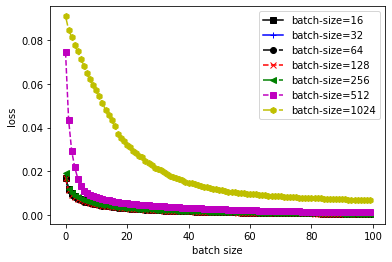

In [76]:

num_epochs = 1000

# batch_sz = [4, 8, 16, 32, 64, 128, 256]
batch_sz = [16, 32, 64, 128, 256, 512, 1024]

def sweep_batch_size(batch_sz):
    losses = []
    print(batch_sz)
    for i_b, b_size in enumerate(batch_sz):
        print('batch_size=', b_size)
        nn = Network((64, 100, 10), (Relu, Sigmoid))
        delta1, delta2, grad1, grad2, loss = nn.fit(x, y, loss=MSE, epochs=num_epochs, batch_size=b_size, learning_rate=1e-3)

        losses.append(loss)
    
        prediction = nn.predict(x)

        y_true = []
        y_pred = []
        for i in range(len(y)):
            y_pred.append(np.argmax(prediction[i]))
            y_true.append(np.argmax(y[i]))

        print(sklearn.metrics.classification_report(y_true, y_pred))
        
    return losses

losses = sweep_batch_size(batch_sz)

#seems medium batch-size is the best
print(len(losses))




batch_size= 16
batch_size= 32
batch_size= 64
batch_size= 128
batch_size= 256
batch_size= 512
batch_size= 1024


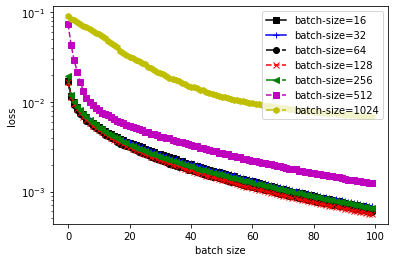

In [77]:

markers = ['-ks', '-b+', '-.ko', '--rx', '-.g<', '--ms', '-.yh']
for i, b in enumerate(batch_sz):
    print('batch_size=', b)
    plt.plot(losses[i], markers[i], label='batch-size='+str(b))

plt.legend()

plt.xlabel('batch size')
plt.ylabel('loss')
plt.yscale('log')
plt.show()


7
batch_size= 4
batch_size= 8
batch_size= 16
batch_size= 32
batch_size= 64
batch_size= 128
batch_size= 256


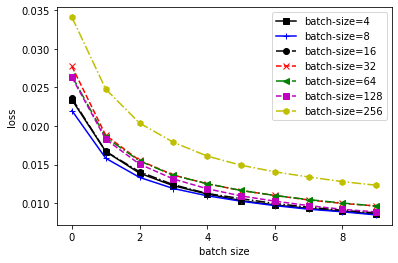

[16, 32, 64, 128, 256]
hidden_size= 16
Loss: 0.03786459304497072
Loss: 0.027467332038800692
Loss: 0.023029267003523278
Loss: 0.019186075359966373
Loss: 0.017223061190108097
Loss: 0.01606505653777009
Loss: 0.015075988617274124
Loss: 0.014360941520329755
Loss: 0.013819498923535036
Loss: 0.013477678617468935
Loss: 0.013108942601725855
Loss: 0.012777125624407294
Loss: 0.012550512364516148
Loss: 0.012282989500212265
Loss: 0.012104620161880457
Loss: 0.011918917794830664
Loss: 0.011739206789134711
Loss: 0.011608853143441617
Loss: 0.011418664117041823
Loss: 0.011292081592298765
Loss: 0.011212680325933894
Loss: 0.011078093804381971
Loss: 0.010960077149878652
Loss: 0.01086764444908821
Loss: 0.010776025447165489
Loss: 0.010681719610633881
Loss: 0.010627605908661401
Loss: 0.010528886811515517
Loss: 0.010423823908190097
Loss: 0.010385959665973768
Loss: 0.010296955641412886
Loss: 0.010217650490937166
Loss: 0.01015209707873741
Loss: 0.01009765404055441
Loss: 0.01001063431456182
Loss: 0.00995742232245

Loss: 0.002111276397712237
Loss: 0.002054943431173197
Loss: 0.0020153201742166373
Loss: 0.001966034892660997
Loss: 0.0019410147865285426
Loss: 0.0018961157166117219
Loss: 0.0018566220013620442
Loss: 0.0018102832556336106
Loss: 0.001774812636590645
Loss: 0.0017416071868602255
Loss: 0.001700865442550851
Loss: 0.0016708922974625112
Loss: 0.0016394269329254086
Loss: 0.0016227363052630757
Loss: 0.0015709781676392241
Loss: 0.0015459108480139702
Loss: 0.0015125015780857005
Loss: 0.0014927615090264562
Loss: 0.0014678673310864166
Loss: 0.0014490940337919542
Loss: 0.0014139411090942837
Loss: 0.0013882225448832465
Loss: 0.0013664362506865908
Loss: 0.001349114393928326
Loss: 0.0013138987565724585
Loss: 0.00128730003431479
Loss: 0.0012714717784322808
Loss: 0.001241971256621271
Loss: 0.001220742081665981
Loss: 0.001203416678111065
Loss: 0.001182205136091165
Loss: 0.0011743165145082772
Loss: 0.0011479635075610217
Loss: 0.001124734691079251
Loss: 0.001105939571754917
Loss: 0.0010917011723402862
Loss: 

Loss: 0.0006648438447300585
Loss: 0.0006568849729581451
Loss: 0.0006482112780931752
Loss: 0.0006313042149930997
Loss: 0.0006212202778353515
Loss: 0.0006105054332123975
Loss: 0.0005982827482974473
Loss: 0.0005847736894655217
Loss: 0.0005759033158482221
Loss: 0.0005700909548808207
Loss: 0.00056041730757291
Loss: 0.0005458497758190957
Loss: 0.0005385498625270325
Loss: 0.0005307317682469066
Loss: 0.0005223560079151093
Loss: 0.0005130573335856281
Loss: 0.0005046610839183915
len(delta1): 1000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       178
           1       1.00      1.00      1.00       182
           2       1.00      1.00      1.00       177
           3       0.99      1.00      1.00       183
           4       1.00      1.00      1.00       181
           5       1.00      0.99      1.00       182
           6       1.00      1.00      1.00       181
           7       1.00      1.00      1.00       179
           8       1.

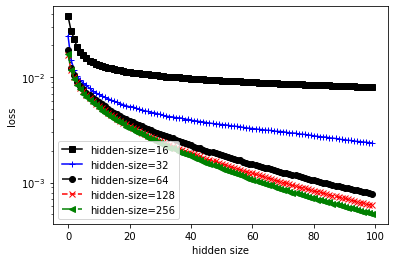

In [80]:
#hidden size the bigger the better
#converges slower and flat in the end. this can be due to w2. 

num_epochs = 1000

hidden_size = [16, 32, 64, 128, 256]

def sweep_hidden_size(hidden_size):
    losses = []
    print(hidden_size)
    for i_b, b_size in enumerate(hidden_size):
        print('hidden_size=', b_size)
        nn = Network((64, b_size, 10), (Relu, Sigmoid))
        delta1, delta2, grad1, grad2, loss = nn.fit(x, y, loss=MSE, epochs=num_epochs, batch_size=32, learning_rate=1e-3)

        losses.append(loss)
    
        prediction = nn.predict(x)

        y_true = []
        y_pred = []
        for i in range(len(y)):
            y_pred.append(np.argmax(prediction[i]))
            y_true.append(np.argmax(y[i]))

        print(sklearn.metrics.classification_report(y_true, y_pred))
        
    return losses

losses = sweep_hidden_size(hidden_size)

#seems medium batch-size is the best
print(len(losses))


markers = ['-ks', '-b+', '-.ko', '--rx', '-.g<', '--ms', '-.yh']
for i, b in enumerate(hidden_size):
    print('hidden_size=', b)
    plt.plot(losses[i], markers[i], label='hidden-size='+str(b))

plt.legend()

plt.xlabel('hidden size')
plt.ylabel('loss')
plt.yscale('log')
plt.show()

